In [1]:
def read(fname):
    with open(fname, 'r') as f:
        return f.read()
    return ''

# Read CSV data from file.
CSV = read('./ic_all_4.csv').replace(' ', '')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
from io import StringIO

# Create DataFrame from CSV data.
df = pd.read_csv(StringIO(CSV))

# Cleanup.
df.drop(columns=['run'], inplace=True)  # Drop 'run' column.
df.drop_duplicates(inplace=True)        # Drop duplicates.

# Calculate new columns.
df['time_diff'] = df.outer_time - df.inner_time
df['time_per_call_ms'] = 1000 * df.inner_time / (df.depth * df.iterations)
df['call_rate'] = 1000 / df.time_per_call_ms

# Remove outliers.
#df = df[df.inner_time<=10.0]
#df = df[df.iterations<=500]
df = df[df.time_diff<15]
df = df[df.time_diff>0]

df.head()

,method,depth,iterations,inner_time,outer_time,time_diff,time_per_call_ms,call_rate
0,compute_iterations,1,300,10.0,13.873401,3.873401,33.333333,30.000000
1,compute_iterations,1,406,10.5,14.442375,3.942375,25.862069,38.666667
2,compute_iterations,1,330,11.0,14.713575,3.713575,33.333333,30.000000
3,compute_iterations,1,435,11.5,16.759531,5.259531,26.436782,37.826087
4,compute_iterations,1,401,12.0,17.178179,5.178179,29.925187,33.416667


In [3]:
df.time_per_call_ms.describe()

count    924.000000
mean      31.006866
std        3.731991
min       22.935780
25%       28.597798
50%       30.540487
75%       32.886416
max       63.725490
Name: time_per_call_ms, dtype: float64

In [4]:
df.time_diff.describe()

count    924.000000
mean       4.626486
std        0.986686
min        2.514579
25%        3.902865
50%        4.513646
75%        5.195206
max        8.611076
Name: time_diff, dtype: float64

In [5]:
_df = df
_df = _df[_df.time_diff <= 0]

_df

,method,depth,iterations,inner_time,outer_time,time_diff,time_per_call_ms,call_rate


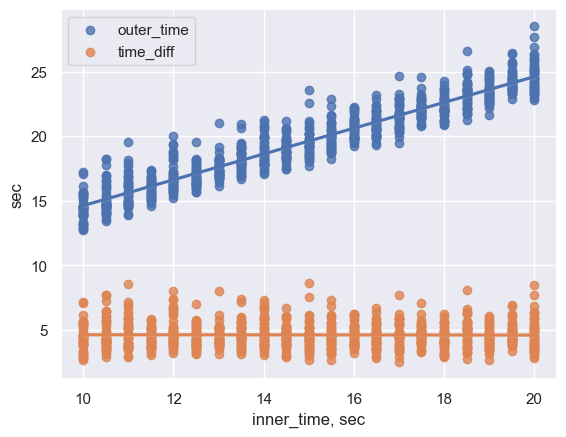

In [6]:
for label in ['outer_time', 'time_diff']:
    ax = sns.regplot(x='inner_time', y=label, data=df, label=label)
    ax.legend()
    ax.set(xlabel='inner_time, sec', ylabel='sec')


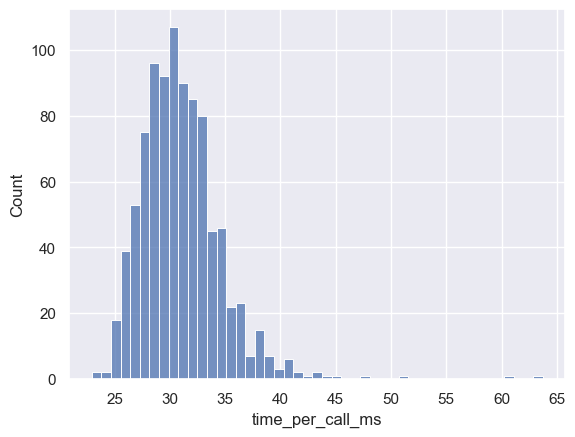

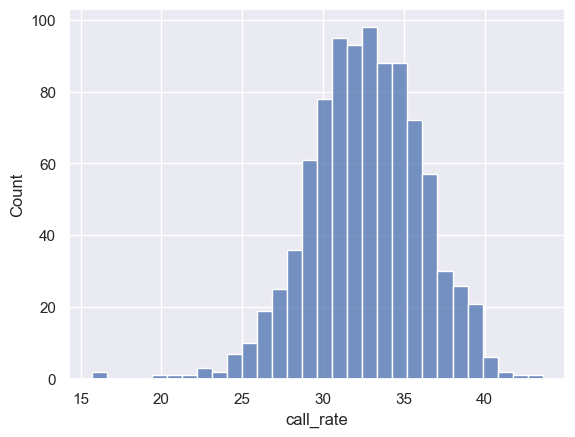

,method,depth,iterations,inner_time,outer_time,time_diff,time_per_call_ms,call_rate
0,compute_iterations,1,300,10.0,13.873401,3.873401,33.333333,30.000000
1,compute_iterations,1,406,10.5,14.442375,3.942375,25.862069,38.666667
2,compute_iterations,1,330,11.0,14.713575,3.713575,33.333333,30.000000
3,compute_iterations,1,435,11.5,16.759531,5.259531,26.436782,37.826087
4,compute_iterations,1,401,12.0,17.178179,5.178179,29.925187,33.416667
...,...,...,...,...,...,...,...,...
919,compute_iterations,4,126,18.0,22.066380,4.066380,35.714286,28.000000
920,compute_iterations,4,160,18.5,23.325691,4.825691,28.906250,34.594595
921,compute_iterations,4,147,19.0,22.995646,3.995646,32.312925,30.947368
922,compute_iterations,4,148,19.5,23.753594,4.253594,32.939189,30.358974


In [7]:
_df = df
_df = _df[_df.time_per_call_ms!=np.inf]

# fig, axs = plt.subplots(1,2)
# sns.histplot(x='time_per_call_ms', data=df).plot(ax=axs[0])
# sns.histplot(x='call_rate', data=df).plot(ax=axs[1])

plt.show(sns.histplot(x='time_per_call_ms', data=df))
plt.show(sns.histplot(x='call_rate', data=df))

# sns.regplot(x='iterations', y='time_per_call_ms', data=df)
# sns.regplot(x='inner_time', y='time_per_call_ms', data=df)
#sns.regplot(x='depth', y='time_per_call_ms', data=df)


_df

<AxesSubplot: xlabel='time_diff', ylabel='Count'>

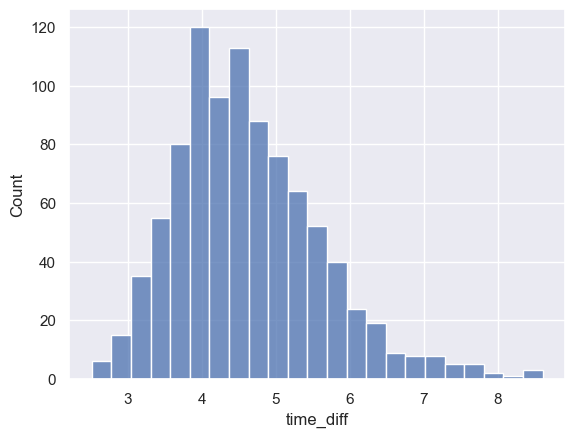

In [8]:
sns.histplot(x='time_diff', data=df)

In [9]:
# Calculate overhead for given time and depth.
INNER_TIME = 10.0
DEPTH = 9

_df = df
_df = _df[(_df.inner_time==INNER_TIME)&(_df.depth==DEPTH)]
_df = _df.groupby(by=['method']).median().reset_index()

# Calculate time per call.
_df['time per call, ms'] = 1000 * _df.inner_time / (_df.iterations * _df.depth)
_df = _df.round(3)

# Calculate overhead.
# a = _df[_df.method=='compute_ab'].inner_time.values[0]
# b = _df[_df.method=='compute_inner'].inner_time.values[0]
# overhead = round(a / b, 2)
# print(f'Inter-Canister Call Overhead: {a} / {b} = {overhead}')

_df

,method,depth,iterations,inner_time,outer_time,time_diff,time_per_call_ms,call_rate,"time per call, ms"


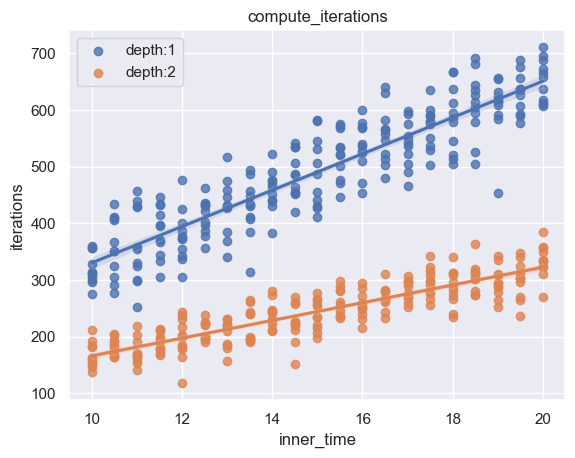

In [10]:
def plot_compute_iterations(df, depths=[1, 2]):
  method = 'compute_iterations'
  _df = df[df.method==method]
  for depth in depths:
    ax = sns.regplot(x="inner_time", y="iterations", data=_df[_df.depth==depth], label=f'depth:{depth}')
    ax.legend()
  ax.set(title=method)

plot_compute_iterations(df)

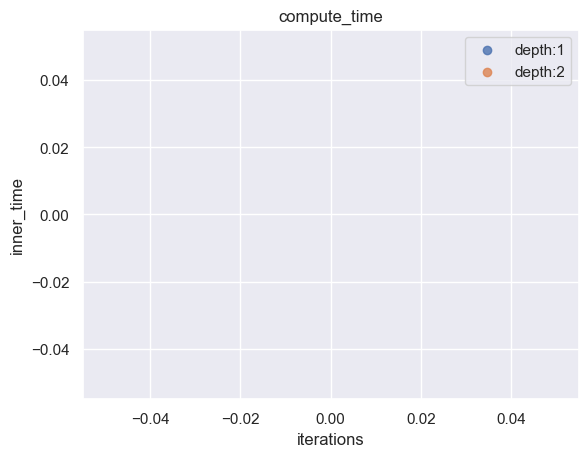

In [11]:
def plot_compute_time(df, depths=[1, 2]):
  method = 'compute_time'
  _df = df[df.method==method]
  for depth in depths:
    ax = sns.regplot(x="iterations", y="inner_time", data=_df[_df.depth==depth], label=f'depth:{depth}')
    ax.legend()
  ax.set(title=method)

plot_compute_time(df)

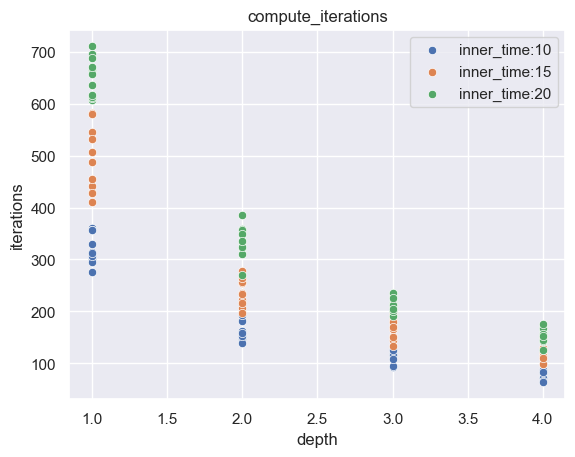

In [12]:
def plot_depth(df):
  method = 'compute_iterations'
  _df = df[df.method==method]
  for inner_time in [10, 15, 20]:
    ax = sns.scatterplot(x="depth", y="iterations", data=_df[_df.inner_time==inner_time], label=f'inner_time:{inner_time}')
    ax.legend()
  ax.set(title=method)

plot_depth(df)